# Setup

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
import pickle
from scipy.stats import norm,wilcoxon,shapiro,ttest_rel
import statistics

In [2]:
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd',
              GOLD = '#FDB119') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
from matplotlib import rcParams
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'

## analysis function

In [3]:
def mean_and_interquartile(data, axis = 0):
    """
    calculate mean and interquartile range of data.
    how to use: 
    mean, quantile25, quantile50, quantile75 = mean_and_interquartile(data, axis)
    """
    mean = np.nanmean(data, axis = axis)
    q25, q50, q75 = np.nanpercentile(data, [25, 50, 75], axis=axis)
    return mean, q25, q50, q75


def WilcoxonTest(all_data):
    """Wilcoxon signed-rank test:  
    tests the null hypothesis that two related paired samples come from the same distribution
    """

    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = wilcoxon(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

## load data

In [164]:
file_folder = "C:\\Users\\amber\\OneDrive - UW\\Sensorimotor Fusion\\pickles\\video_game_analysis\\" # laptop
# file_folder = "" # this folder

file_name = r'time_domain_data_HCPS101_115.pkl' # Amber's CPHS 15 subjects, time domain data
with open(file_folder + file_name, 'rb') as f:
    DATA = pickle.load(f)

file_name = r'time_domain_data_HCPS116_122.pkl' # 7 subject linearity test
with open(file_folder + file_name, 'rb') as f:
    DATA_L = pickle.load(f)

In [165]:
print(DATA.keys())
print(DATA_L.keys())

dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6', 'subject7', 'subject8', 'subject9', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14'])
dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6'])


In [166]:
print(DATA['subject0'].keys())
print(DATA_L['subject0'].keys())

print(DATA['subject0']['condition0'].keys())
print(DATA_L['subject0']['condition0'].keys())

# condition0: slider only
# condition1: EMG only

# r = reference position
# d = disturbance
# y = cursor position
# u = emg input

dict_keys(['condition0', 'condition1', 'condition2', 'condition3', 'condition4', 'condition5', 'condition6'])
dict_keys(['condition0', 'condition1', 'condition2', 'condition3', 'condition4'])
dict_keys(['Md', 'r', 'y', 'd', 'Wr', 'u', 'u0', 'u1'])
dict_keys(['Md', 'r', 'y', 'd', 'Wr', 'u', 'u0', 'u1'])


In [167]:
subject_num = len(DATA)
print(subject_num)

condition_num = 2 # here we only look at the first 2 conditions

trial_num = len(DATA['subject0']['condition0']['r'])
print(trial_num)

trial_num_L = len(DATA_L['subject0']['condition0']['r'])
print(trial_num_L)

15
10
4


## pulling specific subjects 

In [183]:
subjects_to_pull = ['subject4', 'subject11','subject14'] # from the first dictionary
subjects_to_pull_L = ['subject0', 'subject1','subject2','subject3','subject4','subject5','subject6'] # from the second dictionary
len(subjects_to_pull), len(subjects_to_pull_L)

(3, 7)

In [184]:
DATA_new = {'subject0':DATA.get(subjects_to_pull[0]), 
            'subject1':DATA.get(subjects_to_pull[1]),
            'subject2':DATA.get(subjects_to_pull[2]),
            'subject3':DATA_L.get(subjects_to_pull_L[0]),
            'subject4':DATA_L.get(subjects_to_pull_L[1]),
            'subject5':DATA_L.get(subjects_to_pull_L[2]),
            'subject6':DATA_L.get(subjects_to_pull_L[3]),
            'subject7':DATA_L.get(subjects_to_pull_L[4]),
            'subject8':DATA_L.get(subjects_to_pull_L[5]),
            'subject9':DATA_L.get(subjects_to_pull_L[6])}
# DATA_new.update(DATA.get(subjects_to_pull[1]))
# DATA_new.update(DATA.get(subjects_to_pull[2]))
DATA_new.keys()

dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6', 'subject7', 'subject8', 'subject9'])

In [186]:
subject_num = len(DATA_new)
subject_num

10

# Time domain task performance (15 subjects)

## one example trial

In [185]:
fs = 60         # sampling rate (Hz)
t0 = 1/fs       # first time step
T = 40          # total duration (s)
time = np.arange(t0, t0+T, 1/fs) # timestamps
N = len(time)   # number of samples
print(time)
print(N)

[1.66666667e-02 3.33333333e-02 5.00000000e-02 ... 3.99666667e+01
 3.99833333e+01 4.00000000e+01]
2400


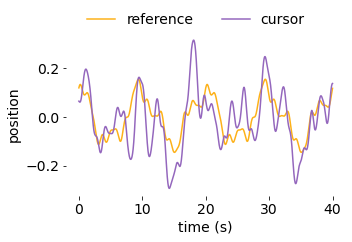

In [214]:
# one example trial of the slider task
iK = 8 # subject
iC = 0 # condition 
iT = -1 # trial
ref = np.asarray(DATA_new['subject'+str(iK)]['condition'+str(iC)]['r'])[iT]
cursor = np.asarray(DATA_new['subject'+str(iK)]['condition'+str(iC)]['y'])[iT]

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(time, ref, label='reference', color = colors['GOLD'])
ax.plot(time, cursor, label='cursor', color = colors['PURPLE'])
ax.legend(bbox_to_anchor = (0.9,1.2),ncol = 2,frameon = False)
ax.set_xlabel('time (s)')
ax.set_ylabel('position')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

## average time domain task error 

In [231]:
# avergae time domain error per condition per subject, averaged across trials
avg_task_performance = np.empty((subject_num, condition_num, N)) 
for iK in range(subject_num):
    for iC in range(condition_num):
        r = np.asarray(DATA_new['subject'+str(iK)]['condition'+str(iC)]['r']) # reference
        y = np.asarray(DATA_new['subject'+str(iK)]['condition'+str(iC)]['y']) # cursor
        e = np.abs(r - y) # time domain error
        avg_task_performance[iK,iC,:] = np.mean( e ,axis=0) # average across trials
print(avg_task_performance.shape) # 10 subject x 2 condition (slider, emg) x time

(10, 2, 2400)


No handles with labels found to put in legend.


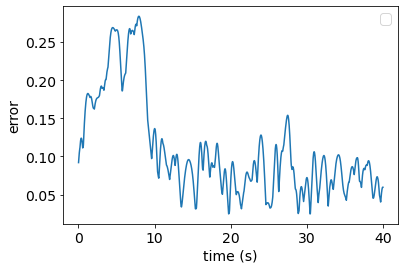

In [232]:
iK = 8 # subject
iC = 0 # condition 
plt.plot(time, avg_task_performance[iK,iC,:])
plt.xlabel('time (s)')
plt.ylabel('error')
plt.legend()
plt.show()

## distribution of time domain error (avg of all trials)

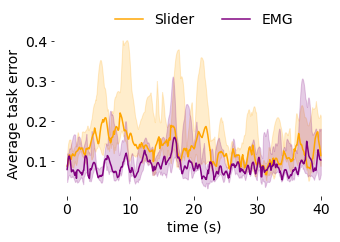

In [241]:
condtion_labels = ['Slider','EMG']
condition_colors = ['orange','purple']
# condition_colors = ['blue','green']
fig, ax = plt.subplots(figsize=(5, 3))
for iC in [0,1]: # condition
    mean, quantile25, quantile50, quantile75 = mean_and_interquartile(avg_task_performance[:,iC,:], axis = 0) # distribution across subjects

    ax.plot(time, quantile50,label = condtion_labels[iC], color = condition_colors[iC]) # median, interquartiles
    ax.fill_between(time, quantile25, quantile75, alpha=0.2, color = condition_colors[iC])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Average task error')
ax.legend(ncol =2 , frameon = False, bbox_to_anchor = (0.9,1.2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()   

# Subjects to pull

In [16]:
# for the first set of exp
subjects_to_pull = ['subject4', 'subject11','subject14']
new_subject_num = len(subjects_to_pull)

ref = np.zeros((new_subject_num, condition_num, trial_num, N))
dis = np.zeros((new_subject_num, condition_num, trial_num, N))
cursor = np.zeros((new_subject_num, condition_num, trial_num, N))
for iK,key in enumerate(subjects_to_pull):
    ref[iK] = np.stack((np.asarray(DATA[key]['condition0']['r']),np.asarray(DATA[key]['condition1']['r'])))
    dis[iK] = np.stack((np.asarray(DATA[key]['condition0']['d']),np.asarray(DATA[key]['condition1']['d'])))
    cursor[iK] = np.stack((np.asarray(DATA[key]['condition0']['y']),np.asarray(DATA[key]['condition1']['y'])))

print(ref.shape) # subject x condition x trial x timestamos (2400)

abs_error = np.abs(ref-cursor)
print(abs_error.shape) # subject x condition x trial x timestamos (2400)

MSE_error = np.mean(abs_error**2,axis = 3) # MSE of each trial
print(MSE_error.shape)  # subject x condition x trial

# MSE of all trials
MSE_error_average_subject = np.mean(MSE_error, axis = (1,2)) # MSE of each trial, take the average across subjects
print(MSE_error_average_subject.shape) # for each subject

# MSE of just EMG trials
MSE_error_average_subject_EMG = np.mean(MSE_error[:,1,:], axis = 1) # MSE of each trial, take the average across subjects
print(MSE_error_average_subject_EMG.shape) # for each subject

# MSE of just slider trials
MSE_error_average_subject_slider = np.mean(MSE_error[:,0,:], axis = 1) # MSE of each trial, take the average across subjects
print(MSE_error_average_subject_slider.shape) # for each subject

(3, 2, 10, 2400)
(3, 2, 10, 2400)
(3, 2, 10)
(3,)
(3,)
(3,)


In [17]:
# for the second set of exp
subjects_to_pull_L = ['subject0', 'subject1', 'subject2', 'subject3', 'subject4','subject5', 'subject6']
new_subject_num_L = len(subjects_to_pull_L)

ref = np.zeros((new_subject_num_L, condition_num, trial_num_L, N))
dis = np.zeros((new_subject_num_L, condition_num, trial_num_L, N))
cursor = np.zeros((new_subject_num_L, condition_num, trial_num_L, N))
for iK,key in enumerate(subjects_to_pull_L):
    ref[iK] = np.stack((np.asarray(DATA_L[key]['condition0']['r']),np.asarray(DATA_L[key]['condition1']['r'])))
    dis[iK] = np.stack((np.asarray(DATA_L[key]['condition0']['d']),np.asarray(DATA_L[key]['condition1']['d'])))
    cursor[iK] = np.stack((np.asarray(DATA_L[key]['condition0']['y']),np.asarray(DATA_L[key]['condition1']['y'])))

print(ref.shape) # subject x condition x trial x timestamos (2400)

abs_error = np.abs(ref-cursor)
print(abs_error.shape) # subject x condition x trial x timestamos (2400)

MSE_error = np.mean(abs_error**2,axis = 3) # MSE of each trial # subject x condition x trial
print(MSE_error.shape)

# MSE of all trials
MSE_error_average_subject_L = np.mean(MSE_error, axis = (1,2)) # MSE of each trial, take the average across subjects
print(MSE_error_average_subject_L.shape) # for each subject

# MSE of just EMG trials
MSE_error_average_subject_EMG_L = np.mean(MSE_error[:,1,:], axis = 1) # MSE of each trial, take the average across subjects
print(MSE_error_average_subject_EMG_L.shape) # for each subject

# MSE of just slider trials
MSE_error_average_subject_slider_L = np.mean(MSE_error[:,0,:], axis = 1) # MSE of each trial, take the average across subjects
print(MSE_error_average_subject_slider_L.shape) # for each subject

(7, 2, 4, 2400)
(7, 2, 4, 2400)
(7, 2, 4)
(7,)
(7,)
(7,)


In [18]:
# for all conditions
MSE_all = np.concatenate((MSE_error_average_subject,MSE_error_average_subject_L))

# for EMG condition
MSE_EMG = np.concatenate((MSE_error_average_subject_EMG,MSE_error_average_subject_EMG_L))

# for slider condition
MSE_slider = np.concatenate((MSE_error_average_subject_slider,MSE_error_average_subject_slider_L))

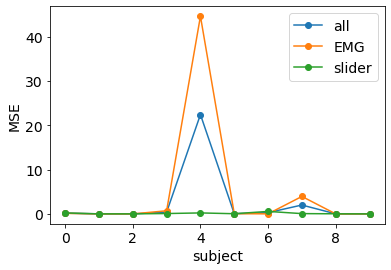

In [19]:
plt.plot(MSE_all,'-o')
plt.plot(MSE_EMG,'-o')
plt.plot(MSE_slider,'-o')
plt.xlabel('subject')
plt.ylabel('MSE')
plt.legend(['all','EMG','slider'])
# plt.ylim([-0.1,2])
plt.show()

# correlation between MSE and hours/week of gaming

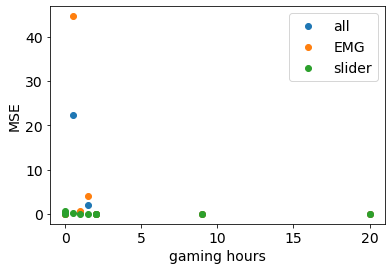

In [20]:
gaming_hours = np.array([0,0,9,1,0.5,2,0,1.5,20,2])

plt.scatter(gaming_hours,MSE_all)
plt.scatter(gaming_hours,MSE_EMG)
plt.scatter(gaming_hours,MSE_slider)
plt.ylabel('MSE')
plt.xlabel('gaming hours')
plt.legend(['all','EMG','slider'])
# plt.xlim(0,5)
# plt.ylim(0,5)
plt.show()

In [ ]:
# gaming_hours = np.array([0,0,9,1,0.5,2,0,1.5,20,2])

# slope, intercept, r, p, std_err = stats.linregress(gaming_hours, MSE_EMG)

# def myfunc(x):
#   return slope * x + intercept

# mymodel = list(map(myfunc, x))

# plt.scatter(gaming_hours,MSE_all)
# plt.scatter(gaming_hours,MSE_EMG)
# plt.plot(gaming_hours, mymodel)
# plt.scatter(gaming_hours,MSE_slider)

# plt.ylabel('MSE')
# plt.xlabel('gaming hours')
# plt.legend(['all','EMG','slider'])
# plt.show()

# Game devices

In [22]:
gaming_devices_list = np.array(["mouse/keyboard","mouse/keyboard", "handheld controller","mobile device", "handheld controller", "touchscreen","mouse/keyboard", "mouse/keyboard", "mouse/keyboard"])
MSE_devices_EMG = np.array([7.12645752e-03, 7.13747462e-01, 7.13747462e-01, 4.46574249e+01, 4.46574249e+01, 6.03655861e-02, 3.95241354e+00, 6.74038744e-03, 5.63767900e-03])
MSE_devices_Slider = np.array([0.02243655, 0.08939555, 0.08939555, 0.23071282, 0.23071282, 0.04775822, 0.07374536, 0.03312134, 0.01516393])

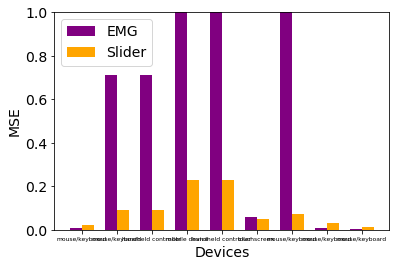

In [23]:
# Width of each bar
bar_width = 0.35

# Create an array of indices for the x-axis
x = range(len(gaming_devices_list))
# Create the bar plot for the first condition
plt.bar(x, MSE_devices_EMG, width=bar_width, label='EMG', color='purple')
# Create the bar plot for the second condition
plt.bar([i + bar_width for i in x], MSE_devices_Slider, width=bar_width, label='Slider', color='orange')
# Set labels for the x and y axes
plt.xlabel('Devices')
plt.ylabel('MSE')
# Set the x-axis tick positions and labels
plt.xticks([i + bar_width / 2 for i in x], gaming_devices_list, fontsize = 6)
plt.ylim(0, 1)
# Add a legend
plt.legend()

## combine the same devices

In [119]:
gaming_devices_list = np.array(["mouse/keyboard","mouse/keyboard", "handheld controller","mobile device", "handheld controller", "touchscreen","mouse/keyboard", "mouse/keyboard", "mouse/keyboard"])
MSE_devices_EMG = np.array([7.12645752e-03, 7.13747462e-01, 7.13747462e-01, 4.46574249e+01, 4.46574249e+01, 6.03655861e-02, 3.95241354e+00, 6.74038744e-03, 5.63767900e-03])
MSE_devices_Slider = np.array([0.02243655, 0.08939555, 0.08939555, 0.23071282, 0.23071282, 0.04775822, 0.07374536, 0.03312134, 0.01516393])

# gaming_devices_list = np.array(["mouse/keyboard","mouse/keyboard", "handheld controller", "touchscreen","mouse/keyboard", "mouse/keyboard", "mouse/keyboard"])
# MSE_devices_EMG = np.array([7.12645752e-03, 7.13747462e-01, 7.13747462e-01, 6.03655861e-02, 3.95241354e+00, 6.74038744e-03, 5.63767900e-03])
# MSE_devices_Slider = np.array([0.02243655, 0.08939555, 0.08939555,0.04775822, 0.07374536, 0.03312134, 0.01516393])


In [120]:
import pandas as pd

my_array = np.stack((MSE_devices_EMG,MSE_devices_Slider))
df = pd.DataFrame(my_array, columns =["mouse/keyboard","mouse/keyboard", "handheld controller","mobile device", "handheld controller", "touchscreen","mouse/keyboard", "mouse/keyboard", "mouse/keyboard"])
# df = pd.DataFrame(my_array, columns =["mouse/keyboard","mouse/keyboard", "handheld controller", "touchscreen","mouse/keyboard", "mouse/keyboard", "mouse/keyboard"])
df = df.T
# print(df)

# call all mobile devices as 'touchscreen'
df.index = df.index.map(lambda x: 'touch screen' if x in ['mobile device', 'touchscreen'] else x)


df.columns = ['EMG', 'slider']
print(df)

                           EMG    slider
mouse/keyboard        0.007126  0.022437
mouse/keyboard        0.713747  0.089396
handheld controller   0.713747  0.089396
touch screen         44.657425  0.230713
handheld controller  44.657425  0.230713
touch screen          0.060366  0.047758
mouse/keyboard        3.952414  0.073745
mouse/keyboard        0.006740  0.033121
mouse/keyboard        0.005638  0.015164


In [123]:
result_df = df.groupby(df.index).mean().reset_index()
# Rename the columns if needed
result_df.columns = ['Devices','EMG', 'slider']

# Print the resulting DataFrame
print(result_df)

               Devices        EMG    slider
0  handheld controller  22.685586  0.160054
1       mouse/keyboard   0.937133  0.046773
2         touch screen  22.358895  0.139236


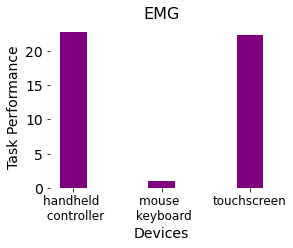

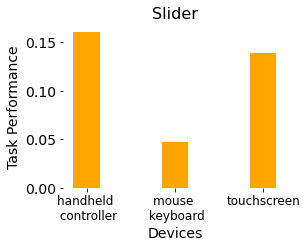

In [124]:
gaming_devices_combine = np.array(["handheld \n controller", "mouse \n keyboard","touchscreen"])
# Width of each bar
bar_width = 0.3
# Create the bar plot for the first condition
fig, ax = plt.subplots(figsize = (4,3))
ax.bar(gaming_devices_combine, result_df.EMG.values, width=bar_width, color='purple')
ax.set_xticklabels(gaming_devices_combine,fontsize=12)
# Set labels for the x and y axes
ax.set_xlabel('Devices')
ax.set_ylabel('Task Performance')
ax.set_title('EMG')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

gaming_devices_combine = np.array(["handheld \n controller", "mouse \n keyboard","touchscreen"])
# Width of each bar
bar_width = 0.3
# Create the bar plot for the first condition
fig, ax = plt.subplots(figsize = (4,3))
ax.bar(gaming_devices_combine, result_df.slider.values, width=bar_width, color='orange')
ax.set_xticklabels(gaming_devices_combine,fontsize=12)
# Set labels for the x and y axes
ax.set_xlabel('Devices')
ax.set_ylabel('Task Performance')
ax.set_title('Slider')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

# barplot for MSE vs hours for slider and emg

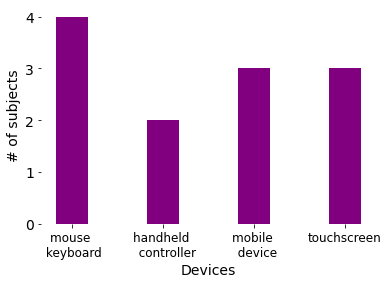

In [125]:
gaming_devices_list = np.array(["mouse \n keyboard", "handheld \n  controller","mobile \n  device", "touchscreen"])
frequency_device = np.array([4, 2, 3, 3])
# Width of each bar
bar_width = 0.35
fig, ax = plt.subplots()
# Create the bar plot for the first condition
ax.bar(gaming_devices_list, frequency_device, width=bar_width, color='purple')
ax.set_xticklabels(gaming_devices_list,fontsize=12)
# Set labels for the x and y axes
ax.set_xlabel('Devices')
ax.set_ylabel('# of subjects')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

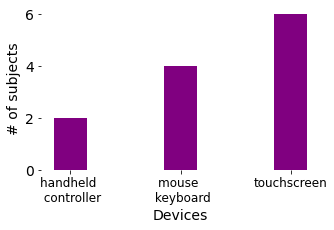

In [130]:
gaming_devices_combine = np.array(["handheld \n controller", "mouse \n keyboard","touchscreen"])
frequency_device = np.array([2,4,6])
# Width of each bar
bar_width = 0.3
fig, ax = plt.subplots(figsize = (5,3))
# Create the bar plot for the first condition
ax.bar(gaming_devices_combine, frequency_device, width=bar_width, color='purple')
ax.set_xticklabels(gaming_devices_combine,fontsize=12)
# Set labels for the x and y axes
ax.set_xlabel('Devices')
ax.set_ylabel('# of subjects')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# frequency of hours barplot

In [37]:
# gave first three all one because i don't have access to this right now
easy_level_EMG = np.array([2, 2, 1, 1, 2, 3, 3, 1, 2, 2])
easy_level_slider = np.array([5, 4, 4, 4, 2, 4, 5, 3, 4, 3])
# Width of each bar
bar_width = 0.35
# Create an array of indices for the x-axis
x = range(len(gaming_hours))

In [38]:
sorted_x, sorted_easy_level_slider = zip(*sorted(zip(x, easy_level_slider)))
sorted_x, sorted_easy_level_EMG = zip(*sorted(zip(x, easy_level_EMG)))

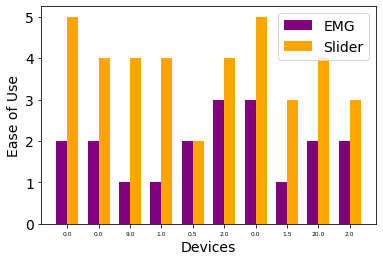

In [39]:
# Create the bar plot for the first condition
plt.bar(sorted_x, sorted_easy_level_EMG, width=bar_width, label='EMG', color='purple')
# Create the bar plot for the second condition
plt.bar([i + bar_width for i in sorted_x], sorted_easy_level_slider, width=bar_width, label='Slider', color='orange')
# Set labels for the x and y axes
plt.xlabel('Devices')
plt.ylabel('Ease of Use')
# Set the x-axis tick positions and labels
plt.xticks([i + bar_width / 2 for i in x], gaming_hours, fontsize = 6)
# Add a legend
plt.legend()

In [40]:
# sorted_easy_level_EMG
sorted_easy_level_EMG, sorted_easy_level_slider

((2, 2, 1, 1, 2, 3, 3, 1, 2, 2), (5, 4, 4, 4, 2, 4, 5, 3, 4, 3))

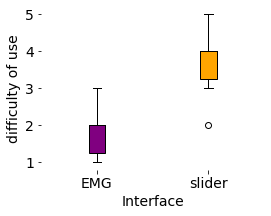

In [41]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize = (4,3))

# Combine the data from both matrices into a single list 
combined_data = [sorted_easy_level_EMG, sorted_easy_level_slider]

# Create the box plot with two boxes for the two matrices
matrix_labels = ['EMG','slider']
box = ax.boxplot(combined_data, labels=matrix_labels, patch_artist=True)

# Set the fill color and median line color for each box
# box_colors = ['darkblue', 'blue','lightblue']
# box_colors = ['#458B74', '#66CDAA','#7FFFD4']
box_colors = ['purple','orange']
median_line_color = 'black'

for i, (patch, color) in enumerate(zip(box['boxes'], box_colors)):
    patch.set_facecolor(color)
    # patch.set_edgecolor('black')  # Set the edge color of the box
    # patch.set_linewidth(1.5)  # Set the line width of the box

    # Find the median line and set its color
    median_line = box['medians'][i]
    median_line.set_color(median_line_color)
    median_line.set_linewidth(1)

# Set the title and labels
# ax.set_title('MSE task error, average across conditions and blocks')
ax.set_ylabel(r'difficulty of use')
ax.set_xlabel('Interface')
# Set the x-axis ticks and labels
# ax.set_xticks(box_x_positions+1)
ax.set_xticklabels(matrix_labels)
# Show the plot
# Set the title and labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(matrix_labels)
plt.show()


# bar plot for ease of use vs. interfaces

In [152]:
Arrays = np.array([[1, 0.0, 3], # ease of use , hours, number of subjects 
                    [1, 0.0, 3],
                    [1, 9.0, 1],
                    [1, 1.0, 1],
                    [1, 0.5, 1],
                    [2, 2.0, 2],
                    [3, 0.0, 3],
                    [1, 1.5, 1],
                    [2, 20.0, 1],
                    [2, 2.0, 2]])
df = pd.DataFrame(Arrays, columns =["difficulty","hours", "frequency"])
df

,difficulty,hours,frequency
0,1.0,0.0,3.0
1,1.0,0.0,3.0
2,1.0,9.0,1.0
3,1.0,1.0,1.0
4,1.0,0.5,1.0
5,2.0,2.0,2.0
6,3.0,0.0,3.0
7,1.0,1.5,1.0
8,2.0,20.0,1.0
9,2.0,2.0,2.0


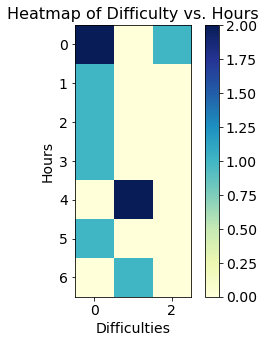

In [155]:
# Create a DataFrame with 10 subjects

# Create a pivot table to count the frequency of each combination
pivot_table = df.pivot_table(index='hours', columns='difficulty', aggfunc='size', fill_value=0)

# Create a heatmap
plt.figure(figsize=(5, 5))
plt.imshow(pivot_table, cmap="YlGnBu")

plt.title('Heatmap of Difficulty vs. Hours')
plt.xlabel('Difficulties')
plt.ylabel('Hours')
plt.colorbar()  # Add a color bar
plt.show()

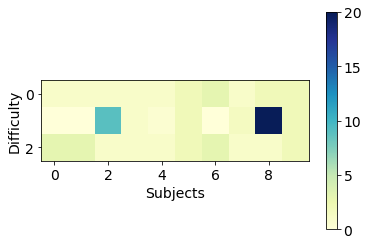

In [131]:
# data_EMG = {"subject 0": [1, 0.0, 3], # ease of use , hours, number of subjects 
#             "subject 1": [1, 0.0, 3],
#             "subject 2": [1, 9.0, 1],
#             "subject 3": [1, 1.0, 1],
#             "subject 4": [1, 0.5, 1],
#             "subject 5": [2, 2.0, 2],
#             "subject 6": [3, 0.0, 3],
#             "subject 7": [1, 1.5, 1],
#             "subject 8": [2, 20.0, 1],
#             "subject 9": [2, 2.0, 2]
# }
# df = pd.DataFrame(data_EMG)

# plt.imshow(df, cmap='YlGnBu')
# plt.xlabel("Subjects")
# plt.ylabel("Difficulty")
# plt.colorbar()  # Add a color bar
# plt.show()